In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
from random import choice

import controllers as c

In [3]:
N_DUPLICATE_PAIRS = 1000
N_MASTER_PAIRS = 4000

reports = []
master_reports = []
duplicate_reports = []
duplicate_pairs = []

reports_db = c.get_reports(limit=10000)
masters = [r for r in reports_db if r.dupe_of is None]
duplicates = [r for r in reports_db if r.dupe_of is not None]

i = 0

while len(duplicate_pairs) < N_DUPLICATE_PAIRS:
    duplicate = duplicates[i]
    try:
        master = c.get_report(duplicate.dupe_of)
        if all([
            master.report_id not in [x.report_id for x in reports],
            duplicate.report_id not in [x.report_id for x in reports]
        ]):
            master_reports.append(master)
            duplicate_reports.append(duplicate)
            reports.extend([master, duplicate])
            duplicate_pairs.append((master, duplicate))
    except:
        pass
    
    i += 1

    if i == len(duplicates):
        print(f"Todos los duplicados ya fueron usados antes de obtener {N_DUPLICATE_PAIRS} duplicados")
        break

while len(master_reports) < N_MASTER_PAIRS:
    report = choice(masters)
    if report.report_id not in [x.report_id for x in reports]:
        master_reports.append(report)
        reports.append(report)

master_pairs = []

while len(master_pairs) < N_MASTER_PAIRS:
    pair = (choice(master_reports), choice(master_reports))
    if pair not in master_pairs and pair[0] != pair[1]:
        master_pairs.append(pair)

In [4]:
len(master_reports), len(duplicate_reports), len(reports)

(4000, 1000, 5000)

In [6]:
columns = [c for c in list(master_reports[0].__dict__.keys()) if c != '_id']
df_reports_master = pd.DataFrame(columns=columns, data=[r.__dict__ for r in master_reports])
df_reports_master['report_id'].duplicated().sum()

0

In [7]:
columns = [c for c in list(duplicate_reports[0].__dict__.keys()) if c != '_id']
df_reports_duplicate = pd.DataFrame(columns=columns, data=[r.__dict__ for r in duplicate_reports])
df_reports_duplicate['report_id'].duplicated().sum()

0

In [8]:
print(f"Se tienen {len(master_reports)} reportes maestros")
print(f"Se tienen {len(duplicate_reports)} reportes duplicados")
print(f"Total de reportes del conjunto: {len(reports)}")
print()
print(f"Se obtuvieron {len(master_pairs)} pares maestro-maestro")
print(f"Se obtuvieron {len(duplicate_pairs)} pares maestro-duplicado")
print(f"Total pares: {len(master_pairs)+len(duplicate_pairs)}")

Se tienen 4000 reportes maestros
Se tienen 1000 reportes duplicados
Total de reportes del conjunto: 5000

Se obtuvieron 4000 pares maestro-maestro
Se obtuvieron 1000 pares maestro-duplicado
Total pares: 5000


In [9]:
columns = [c for c in list(reports[0].__dict__.keys()) if c != '_id']
df_reports = pd.DataFrame(columns=columns, data=[r.__dict__ for r in reports])

In [10]:
df_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   report_id      5000 non-null   int64         
 1   creation_time  5000 non-null   datetime64[ns]
 2   status         5000 non-null   object        
 3   component      5000 non-null   object        
 4   dupe_of        1023 non-null   float64       
 5   summary        5000 non-null   object        
 6   comments       5000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 273.6+ KB


In [11]:
PAIR_COLUMNS = [
    'type', 
    'id_M', 'id_D', 'statusM', 'statusD', 'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM', 'commentsD'
]

df_duplicate_pairs = pd.DataFrame(columns=PAIR_COLUMNS)
df_master_pairs = pd.DataFrame(columns=PAIR_COLUMNS)

for pair in duplicate_pairs:
    df_pair = pd.DataFrame(columns=PAIR_COLUMNS, data=[{
        'type': 'duplicate',
        'id_M': pair[0].report_id,
        'id_D': pair[1].report_id,
        'statusM': pair[0].status,
        'statusD': pair[1].status,
        'componentM': pair[0].component,
        'componentD': pair[1].component,
        'summaryM': pair[0].summary,
        'summaryD': pair[1].summary,
        'commentsM': pair[0].comments,
        'commentsD': pair[1].comments
    }])
    df_duplicate_pairs = pd.concat([df_duplicate_pairs, df_pair])

for pair in master_pairs:
    df_pair = pd.DataFrame(columns=PAIR_COLUMNS, data=[{
        'type': 'master',
        'id_M': pair[0].report_id,
        'id_D': pair[1].report_id,
        'statusM': pair[0].status,
        'statusD': pair[1].status,
        'componentM': pair[0].component,
        'componentD': pair[1].component,
        'summaryM': pair[0].summary,
        'summaryD': pair[1].summary,
        'commentsM': pair[0].comments,
        'commentsD': pair[1].comments
    }])
    df_master_pairs = pd.concat([df_master_pairs, df_pair])

df_report_pairs = pd.concat([df_duplicate_pairs, df_master_pairs])

df_report_pairs.reset_index(drop=True, inplace=True)
df_duplicate_pairs.reset_index(drop=True, inplace=True)
df_master_pairs.reset_index(drop=True, inplace=True)


In [12]:
df_report_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,commentsD
1630,master,1761412,1768687,VERIFIED,RESOLVED,Address Bar,Firefox View,Address bar strings are not updated after live...,Add title/header on top left to Firefox View page,##### [Description:]\nWhen live switching lan...,There isn't currently anything in the first gr...
1777,master,1661009,469456,RESOLVED,NEW,Top Sites,Preferences,Implement basic locale filtering for remote to...,browser.tabs.loadInBackground and browser.tabs...,+++ This bug was initially created as a clone ...,Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...
1259,master,1749910,1635548,VERIFIED,RESOLVED,Networking,General,[2022-01-13] Hangs in socket thread,"Migrate browser-context.inc to Fluent, part 2",**[Affected versions]:**\n- Firefox Release - ...,"After bug 1600528 landed, we still have 24 DTD..."


# Búsqueda de patrones entre pares maestro-duplicado

## Campos 'status' y 'component'

In [13]:
# Get the number of rows with statusM = statusD
same_status_pairs = df_duplicate_pairs[(df_duplicate_pairs.statusM == df_duplicate_pairs.statusD)]
same_component_pairs = df_duplicate_pairs[(df_duplicate_pairs.componentM == df_duplicate_pairs.componentD)]
print(f"Número de pares de duplicados con mismo estado: {len(same_status_pairs)} ({len(same_status_pairs) / len(df_duplicate_pairs) * 100:.2f}% de los duplicados)")
print(f"Número de pares de duplicados con mismo componente: {len(same_component_pairs)} ({len(same_component_pairs) / len(df_duplicate_pairs) * 100:.2f}% de los duplicados)")

status_counts = {}
for status in df_duplicate_pairs.statusM.unique():
    status_counts[status] = len(df_duplicate_pairs[(df_duplicate_pairs.statusM == status) & (df_duplicate_pairs.statusD == status)])
status_counts = sorted(status_counts.items(), key=lambda x: x[1], reverse=True)
status_counts = [x for x in status_counts if x[1] > 0]

component_counts = {}
for component in df_duplicate_pairs.componentM.unique():
    component_counts[component] = len(df_duplicate_pairs[(df_duplicate_pairs.componentM == component) & (df_duplicate_pairs.componentD == component)])
component_counts = sorted(component_counts.items(), key=lambda x: x[1], reverse=True)
component_counts = [x for x in component_counts if x[1] > 0]

Número de pares de duplicados con mismo estado: 297 (29.70% de los duplicados)
Número de pares de duplicados con mismo componente: 646 (64.60% de los duplicados)


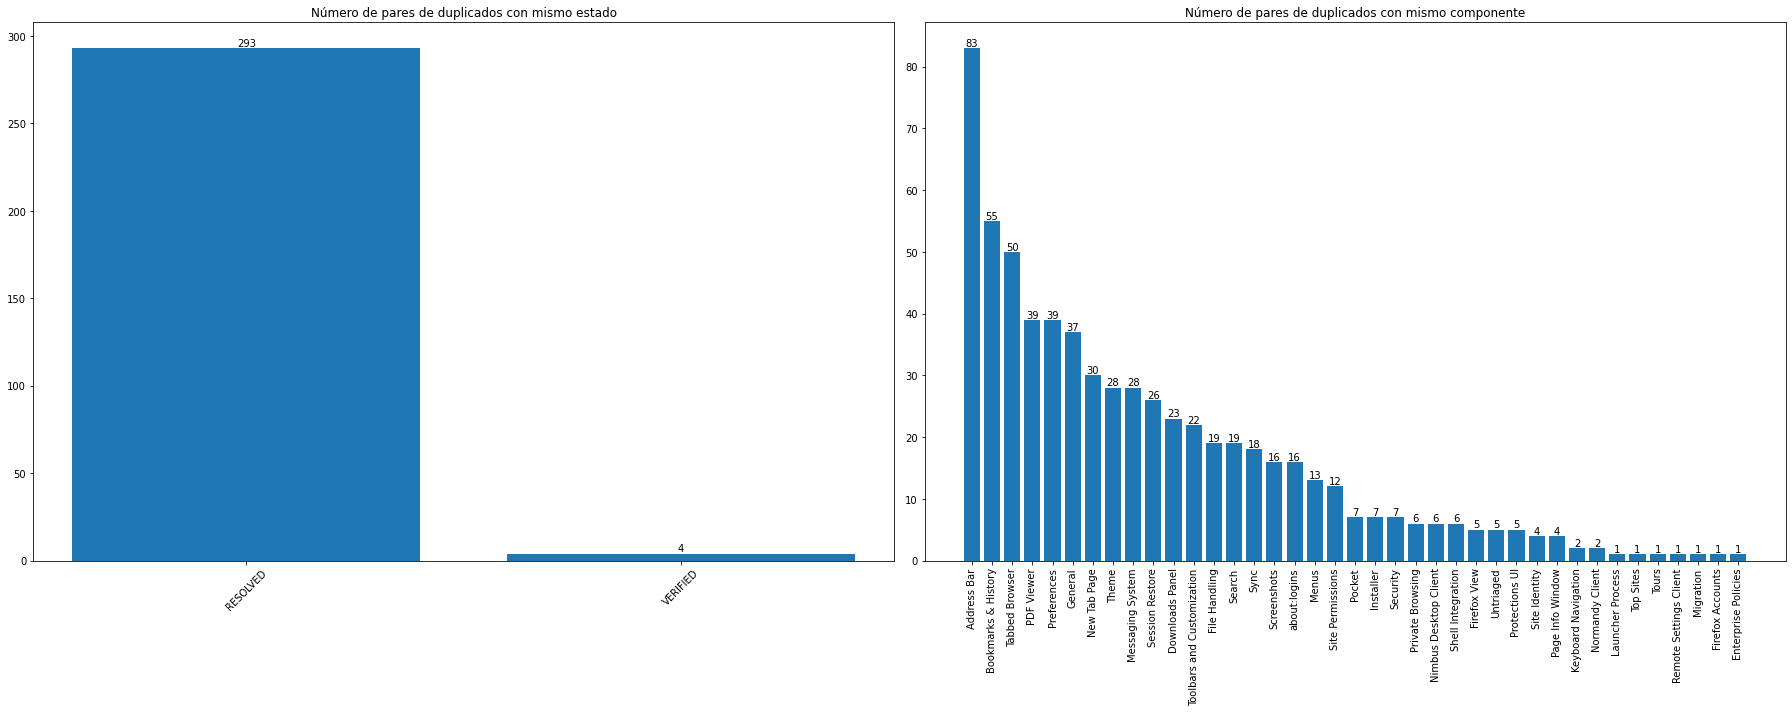

In [14]:
import matplotlib.pyplot as plt

# subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 10))

# plot status counts
axs[0].bar(range(len(status_counts)), [count for status, count in status_counts], align='center')
axs[0].set_xticks(range(len(status_counts)))
axs[0].set_xticklabels([status for status, count in status_counts], rotation=45)
axs[0].set_title('Número de pares de duplicados con mismo estado')
for i, (status, count) in enumerate(status_counts):
    axs[0].text(i, count, count, ha='center', va='bottom')

# plot component counts
axs[1].bar(range(len(component_counts)), [count for component, count in component_counts], align='center')
axs[1].set_xticks(range(len(component_counts)))
axs[1].set_xticklabels([component for component, count in component_counts], rotation=90)
axs[1].set_title('Número de pares de duplicados con mismo componente')
for i, (component, count) in enumerate(component_counts):
    axs[1].text(i, count, count, ha='center', va='bottom')

fig.tight_layout()
plt.show()

## Campos 'summary' y 'comments'

### Creación de varios conjuntos

In [15]:
for i, row in df_reports.iterrows():
    # Conjunto 1: text = summary
    df_reports.at[i, 'text1'] = row.summary
    # Conjunto 2: text = summary + component
    df_reports.at[i, 'text2'] = row.summary + ' ' + row.component
    # Conjunto 3: text = summary + comments (si len(comments) < 1000)
    df_reports.at[i, 'text3'] = row.summary if len(row.comments) > 1000 else row.summary + ' ' + row.comments
    # Conjunto 4: text = summary + component + comments (si len(comments) < 250)
    if len(row.comments) > 250:
        df_reports.at[i, 'text4'] = row.summary + ' ' + row.component
    else:
        df_reports.at[i, 'text4'] = row.summary + ' ' + row.component + ' ' + row.comments


In [16]:
for i, row in df_report_pairs.iterrows():
    # Conjunto 1: text = summary
    df_report_pairs.at[i, 'text1M'] = row.summaryM
    df_report_pairs.at[i, 'text1D'] = row.summaryD
    # Conjunto 2: text = summary + component
    df_report_pairs.at[i, 'text2M'] = row.summaryM + ' ' + row.componentM
    df_report_pairs.at[i, 'text2D'] = row.summaryD + ' ' + row.componentD
    # Conjunto 3: text = summary + comments (si len(comments) < 1000)
    df_report_pairs.at[i, 'text3M'] = row.summaryM if len(row.commentsM) > 1000 else row.summaryM + ' ' + row.commentsM
    df_report_pairs.at[i, 'text3D'] = row.summaryD if len(row.commentsD) > 1000 else row.summaryD + ' ' + row.commentsD
    # Conjunto 4: text = summary + component + comments (si len(comments) < 250)
    if len(row.commentsM) > 250:
        df_report_pairs.at[i, 'text4M'] = row.summaryM + ' ' + row.componentM
    else:
        df_report_pairs.at[i, 'text4M'] = row.summaryM + ' ' + row.componentM + ' ' + row.commentsM
    if len(row.commentsD) > 250:
        df_report_pairs.at[i, 'text4D'] = row.summaryD + ' ' + row.componentD
    else:
        df_report_pairs.at[i, 'text4D'] = row.summaryD + ' ' + row.componentD + ' ' + row.commentsD


### Longitudes y diferencias de longitudes

In [17]:
df_report_pairs['summaryM_len'] = df_report_pairs.summaryM.apply(len)
df_report_pairs['summaryD_len'] = df_report_pairs.summaryD.apply(len)
df_report_pairs['summary_len_diff'] = df_report_pairs.summaryM_len - df_report_pairs.summaryD_len

df_report_pairs['commentsM_len'] = df_report_pairs.commentsM.apply(len)
df_report_pairs['commentsD_len'] = df_report_pairs.commentsD.apply(len)
df_report_pairs['comments_len_diff'] = df_report_pairs.commentsM_len - df_report_pairs.commentsD_len

df_report_pairs['text1M_len1'] = df_report_pairs.text1M.apply(len)
df_report_pairs['text1D_len'] = df_report_pairs.text1D.apply(len)
df_report_pairs['text1_len_diff'] = df_report_pairs.text1M_len1 - df_report_pairs.text1D_len

df_report_pairs['text2M_len'] = df_report_pairs.text2M.apply(len)
df_report_pairs['text2D_len'] = df_report_pairs.text2D.apply(len)
df_report_pairs['text2_len_diff'] = df_report_pairs.text2M_len - df_report_pairs.text2D_len

df_report_pairs['text3M_len'] = df_report_pairs.text3M.apply(len)
df_report_pairs['text3D_len'] = df_report_pairs.text3D.apply(len)
df_report_pairs['text3_len_diff'] = df_report_pairs.text3M_len - df_report_pairs.text3D_len

df_report_pairs['text4M_len'] = df_report_pairs.text4M.apply(len)
df_report_pairs['text4D_len'] = df_report_pairs.text4D.apply(len)
df_report_pairs['text4_len_diff'] = df_report_pairs.text4M_len - df_report_pairs.text4D_len

In [18]:
df_duplicate_pairs = df_report_pairs[df_report_pairs.type == 'duplicate']
df_master_pairs = df_report_pairs[df_report_pairs.type == 'master']

df_duplicate_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,...,text1_len_diff,text2M_len,text2D_len,text2_len_diff,text3M_len,text3D_len,text3_len_diff,text4M_len,text4D_len,text4_len_diff
22,duplicate,1783688,1783759,ASSIGNED,RESOLVED,Address Bar,Address Bar,"Open Inspector, View Source and Print Quick Ac...","QuickActions ""Open Inspector"" button is unnece...","**Note**\n* Inspector, View Source and Print a...",...,-7,97,104,-7,886,937,-51,97,104,-7
673,duplicate,1731495,1731469,RESOLVED,RESOLVED,WebRTC,Untriaged,xdg-desktop-portal 1.10.0 breaks pipewire support,PipeWire screenshare broken with xdg-desktop-p...,See a fix for this issue in OBS: https://githu...,...,-9,56,68,-12,389,731,-342,56,68,-12
748,duplicate,1686705,1725672,NEW,RESOLVED,Address Bar,Address Bar,"""Switch to tab"" suggested for tabs that are no...","Intermittently, ""Switch to tab"" is shown incor...",Using latest Nightly.\n\nI don't have specific...,...,42,106,64,42,1035,808,227,106,64,42


In [19]:
df_duplicate_pairs[[
       'summaryM_len', 'summaryD_len', 'summary_len_diff',
       'commentsM_len', 'commentsD_len', 'comments_len_diff'
]].describe()

,summaryM_len,summaryD_len,summary_len_diff,commentsM_len,commentsD_len,comments_len_diff
count,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000
mean,85.493000,96.14000,-10.64700,1151.927000,2660.068000,-1508.141000
std,38.830371,60.94094,52.51175,3790.460097,5493.068279,5273.012862
min,14.000000,9.00000,-198.00000,0.000000,0.000000,-45012.000000
25%,57.000000,52.00000,-31.00000,48.250000,467.750000,-1445.500000
50%,82.000000,77.00000,0.00000,464.000000,781.000000,-156.500000
75%,105.000000,117.00000,17.00000,843.250000,2173.250000,180.250000
max,255.000000,255.00000,142.00000,54754.000000,54988.000000,50355.000000


In [20]:
df_duplicate_pairs[[
    'text1M_len1', 'text1D_len', 'text2M_len', 'text2D_len', 
    'text3M_len', 'text3D_len',  'text4M_len', 'text4D_len', 
    'text1_len_diff', 'text2_len_diff', 'text3_len_diff', 'text4_len_diff'
]].describe()

,text1M_len1,text1D_len,text2M_len,text2D_len,text3M_len,text3D_len,text4M_len,text4D_len,text1_len_diff,text2_len_diff,text3_len_diff,text4_len_diff
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,85.493000,96.14000,99.151000,109.045000,374.891000,408.616000,115.265000,118.712000,-10.64700,-9.894000,-33.725000,-3.447000
std,38.830371,60.94094,39.740855,61.903142,300.977389,288.792482,59.960788,69.603863,52.51175,53.021789,336.529055,78.075636
min,14.000000,9.00000,22.000000,19.000000,23.000000,17.000000,24.000000,19.000000,-198.00000,-198.000000,-993.000000,-294.000000
25%,57.000000,52.00000,70.000000,64.000000,105.000000,148.750000,74.000000,67.000000,-31.00000,-31.000000,-154.250000,-36.000000
50%,82.000000,77.00000,97.000000,90.000000,275.000000,359.000000,106.000000,96.000000,0.00000,0.000000,-27.500000,0.000000
75%,105.000000,117.00000,119.250000,130.250000,607.500000,623.750000,129.000000,151.250000,17.00000,18.000000,89.500000,23.000000
max,255.000000,255.00000,274.000000,282.000000,1144.000000,1099.000000,387.000000,376.000000,142.00000,152.000000,1009.000000,291.000000


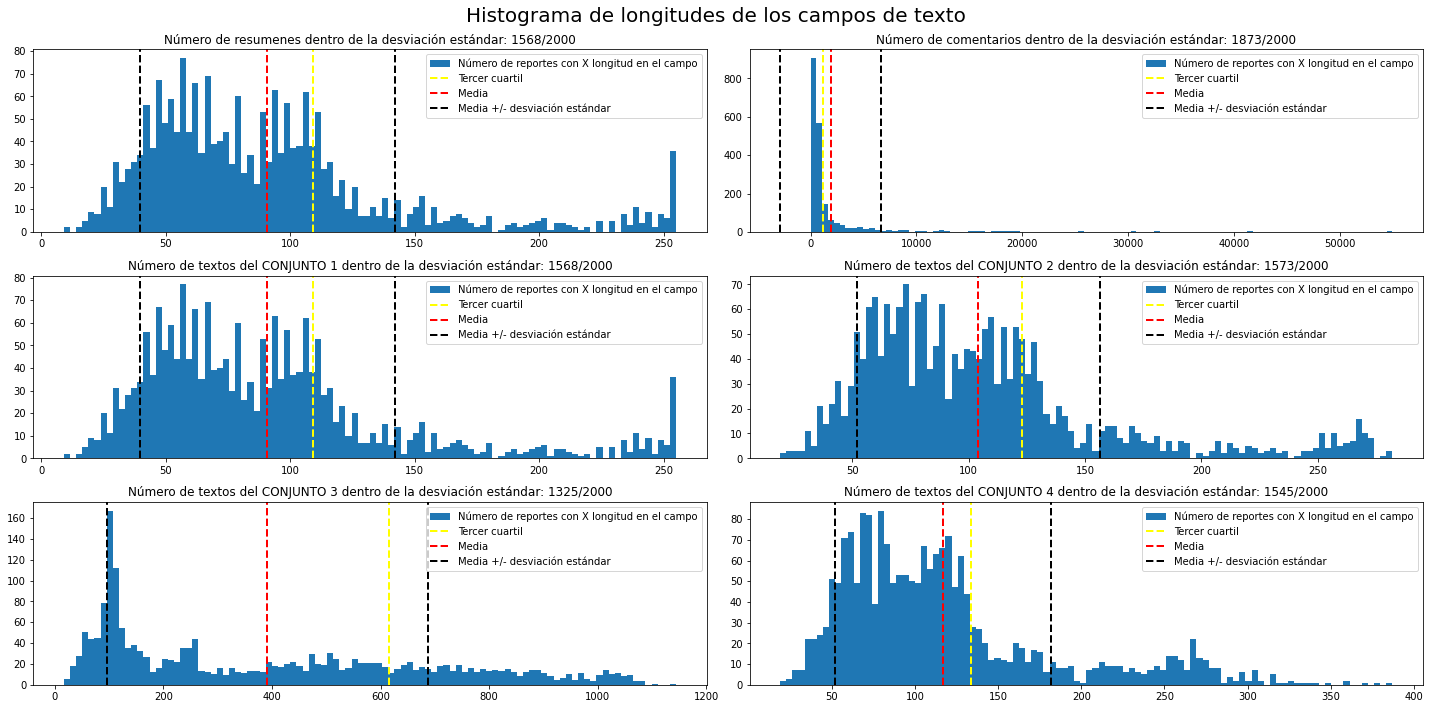

In [21]:
summaries = df_duplicate_pairs[['summaryM_len', 'summaryD_len']].values.flatten()
comments = df_duplicate_pairs[['commentsM_len', 'commentsD_len']].values.flatten()
text1 = df_duplicate_pairs[['text1M_len1', 'text1D_len']].values.flatten()
text2 = df_duplicate_pairs[['text2M_len', 'text2D_len']].values.flatten()
text3 = df_duplicate_pairs[['text3M_len', 'text3D_len']].values.flatten()
text4 = df_duplicate_pairs[['text4M_len', 'text4D_len']].values.flatten()

fig, axs = plt.subplots(3, 2, figsize=(20, 10))

fig.suptitle('Histograma de longitudes de los campos de texto', fontsize=20)

summary_lens_inside_std_count = len(summaries[(summaries > summaries.mean() - summaries.std()) & (summaries < summaries.mean() + summaries.std())])
axs[0,0].hist(summaries, bins=100 , label='Número de reportes con X longitud en el campo')
axs[0,0].axvline(x=np.percentile(summaries,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,0].axvline(x=summaries.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,0].axvline(x=summaries.mean() - summaries.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[0,0].axvline(x=summaries.mean() + summaries.std(), color='black', linestyle='dashed', linewidth=2)
axs[0,0].set_title(f'Número de resumenes dentro de la desviación estándar: {summary_lens_inside_std_count}/{len(summaries)}')
axs[0,0].legend()

comment_lens_inside_std_count = len(comments[(comments > comments.mean() - comments.std()) & (comments < comments.mean() + comments.std())])
axs[0,1].hist(comments, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[0,1].axvline(x=np.percentile(comments,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,1].axvline(x=comments.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,1].axvline(x=comments.mean() - comments.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[0,1].axvline(x=comments.mean() + comments.std(), color='black', linestyle='dashed', linewidth=2)
axs[0,1].set_title(f'Número de comentarios dentro de la desviación estándar: {comment_lens_inside_std_count}/{len(comments)}')
axs[0,1].legend()

text1_lens_inside_std_count = len(text1[(text1 > text1.mean() - text1.std()) & (text1 < text1.mean() + text1.std())])
axs[1,0].hist(text1, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[1,0].axvline(x=np.percentile(text1,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,0].axvline(x=text1.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,0].axvline(x=text1.mean() - text1.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[1,0].axvline(x=text1.mean() + text1.std(), color='black', linestyle='dashed', linewidth=2)
axs[1,0].set_title(f'Número de textos del CONJUNTO 1 dentro de la desviación estándar: {text1_lens_inside_std_count}/{len(text1)}')
axs[1,0].legend()

text2_lens_inside_std_count = len(text2[(text2 > text2.mean() - text2.std()) & (text2 < text2.mean() + text2.std())])
axs[1,1].hist(text2, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[1,1].axvline(x=np.percentile(text2,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,1].axvline(x=text2.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,1].axvline(x=text2.mean() - text2.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[1,1].axvline(x=text2.mean() + text2.std(), color='black', linestyle='dashed', linewidth=2)
axs[1,1].set_title(f'Número de textos del CONJUNTO 2 dentro de la desviación estándar: {text2_lens_inside_std_count}/{len(text2)}')
axs[1,1].legend()

text3_lens_inside_std_count = len(text3[(text3 > text3.mean() - text3.std()) & (text3 < text3.mean() + text3.std())])
axs[2,0].hist(text3, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[2,0].axvline(x=np.percentile(text3,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,0].axvline(x=text3.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,0].axvline(x=text3.mean() - text3.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[2,0].axvline(x=text3.mean() + text3.std(), color='black', linestyle='dashed', linewidth=2)
axs[2,0].set_title(f'Número de textos del CONJUNTO 3 dentro de la desviación estándar: {text3_lens_inside_std_count}/{len(text3)}')
axs[2,0].legend()

text4_lens_inside_std_count = len(text4[(text4 > text4.mean() - text4.std()) & (text4 < text4.mean() + text4.std())])
axs[2,1].hist(text4, bins=100 ,label='Número de reportes con X longitud en el campo')
axs[2,1].axvline(x=np.percentile(text4,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,1].axvline(x=text4.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,1].axvline(x=text4.mean() - text4.std(), color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar')
axs[2,1].axvline(x=text4.mean() + text4.std(), color='black', linestyle='dashed', linewidth=2)
axs[2,1].set_title(f'Número de textos del CONJUNTO 4 dentro de la desviación estándar: {text4_lens_inside_std_count}/{len(text4)}')
axs[2,1].legend()

fig.tight_layout()
plt.show()

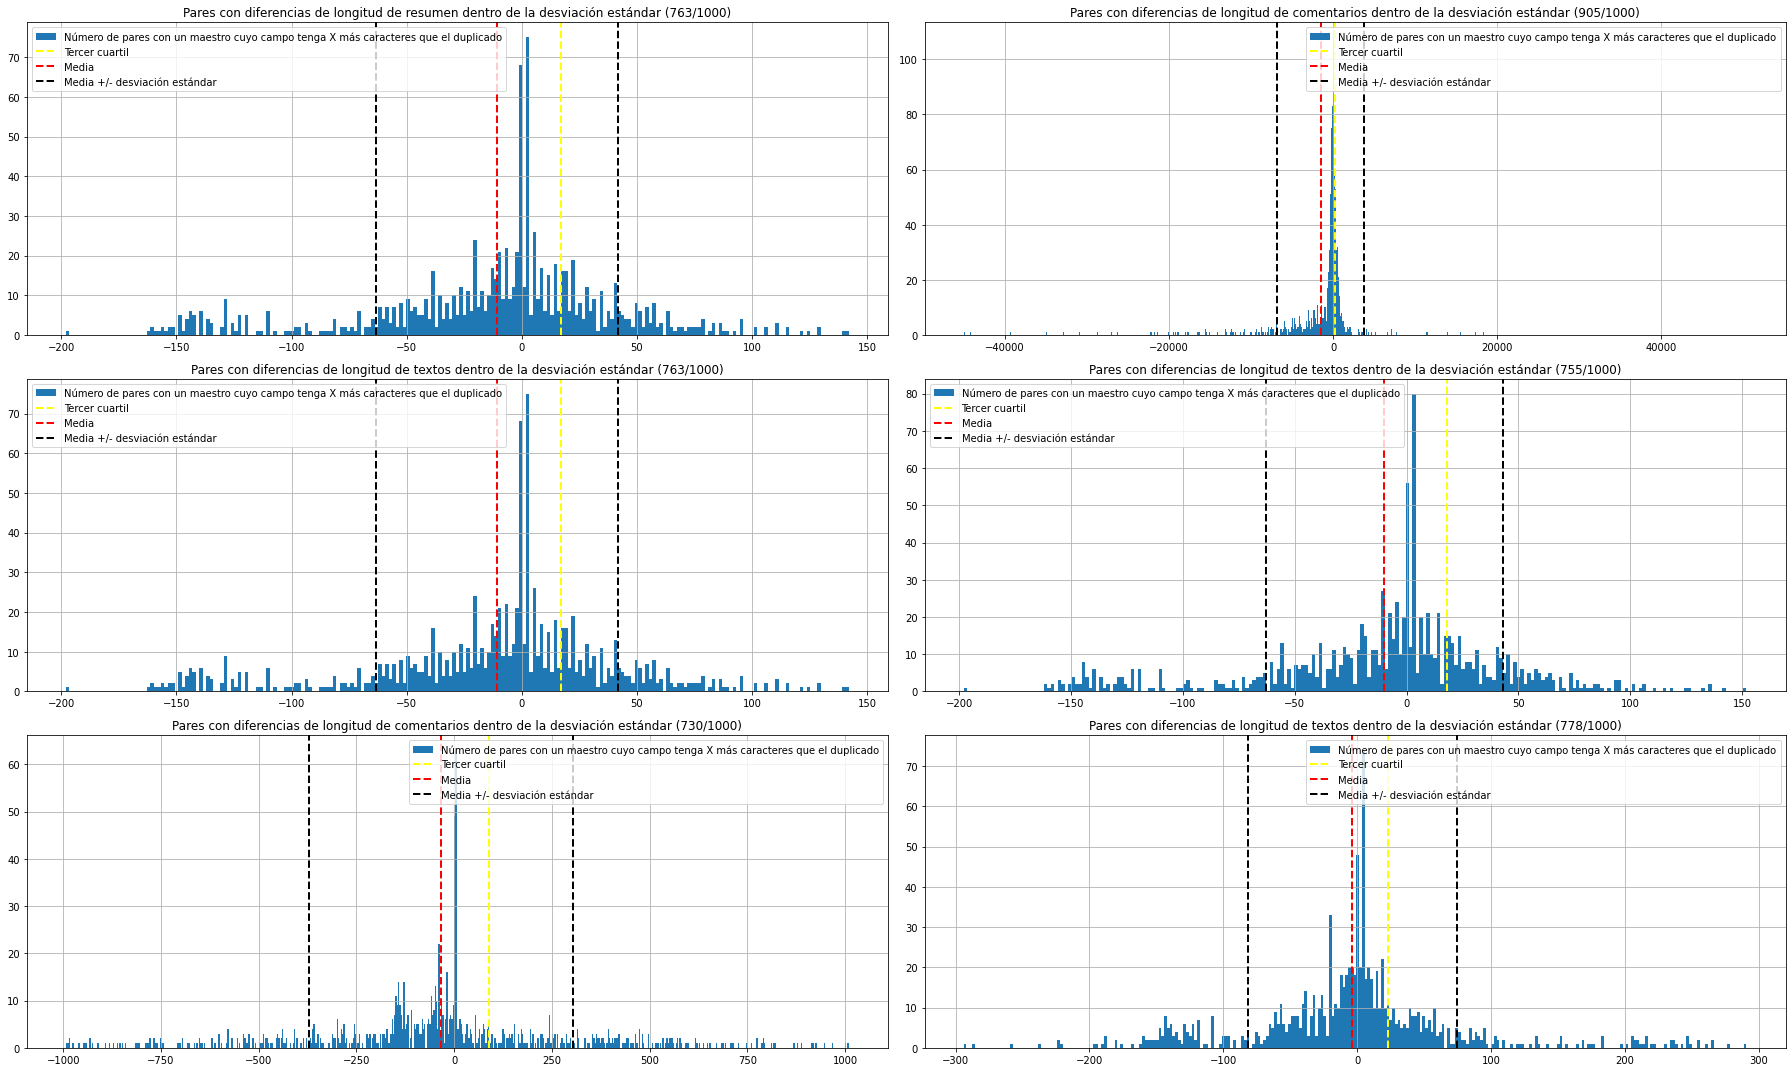

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(25, 15))


df_duplicate_pairs.hist(column='summary_len_diff', ax=axs[0,0], 
                        bins=len(df_duplicate_pairs.summary_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[0,0].axvline(x=np.percentile(df_duplicate_pairs.summary_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,0].axvline(x=df_duplicate_pairs.summary_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,0].axvline(x=df_duplicate_pairs.summary_len_diff.mean() - df_duplicate_pairs.summary_len_diff.std(), 
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[0,0].axvline(x=df_duplicate_pairs.summary_len_diff.mean() + df_duplicate_pairs.summary_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
summary_diff_inside_std_count = df_duplicate_pairs.summary_len_diff.between(
    df_duplicate_pairs.summary_len_diff.mean() - df_duplicate_pairs.summary_len_diff.std(),
    df_duplicate_pairs.summary_len_diff.mean() + df_duplicate_pairs.summary_len_diff.std()
).sum()
axs[0,0].set_title(f'Pares con diferencias de longitud de resumen dentro de la desviación estándar ({summary_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[0,0].legend()


df_duplicate_pairs.hist(column='comments_len_diff', ax=axs[0,1],
                        bins=len(df_duplicate_pairs.comments_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[0,1].axvline(x=np.percentile(df_duplicate_pairs.comments_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[0,1].axvline(x=df_duplicate_pairs.comments_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[0,1].axvline(x=df_duplicate_pairs.comments_len_diff.mean() - df_duplicate_pairs.comments_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[0,1].axvline(x=df_duplicate_pairs.comments_len_diff.mean() + df_duplicate_pairs.comments_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
comments_diff_inside_std_count = df_duplicate_pairs.comments_len_diff.between(
    df_duplicate_pairs.comments_len_diff.mean() - df_duplicate_pairs.comments_len_diff.std(),
    df_duplicate_pairs.comments_len_diff.mean() + df_duplicate_pairs.comments_len_diff.std()
).sum()
axs[0,1].set_title(f'Pares con diferencias de longitud de comentarios dentro de la desviación estándar ({comments_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[0,1].legend()


df_duplicate_pairs.hist(column='text1_len_diff', ax=axs[1,0],
                        bins=len(df_duplicate_pairs.text1_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[1,0].axvline(x=np.percentile(df_duplicate_pairs.text1_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,0].axvline(x=df_duplicate_pairs.text1_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,0].axvline(x=df_duplicate_pairs.text1_len_diff.mean() - df_duplicate_pairs.text1_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[1,0].axvline(x=df_duplicate_pairs.text1_len_diff.mean() + df_duplicate_pairs.text1_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text1_diff_inside_std_count = df_duplicate_pairs.text1_len_diff.between(
    df_duplicate_pairs.text1_len_diff.mean() - df_duplicate_pairs.text1_len_diff.std(),
    df_duplicate_pairs.text1_len_diff.mean() + df_duplicate_pairs.text1_len_diff.std()
).sum()
axs[1,0].set_title(f'Pares con diferencias de longitud de textos dentro de la desviación estándar ({text1_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[1,0].legend()


df_duplicate_pairs.hist(column='text2_len_diff', ax=axs[1,1],
                        bins=len(df_duplicate_pairs.text2_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[1,1].axvline(x=np.percentile(df_duplicate_pairs.text2_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[1,1].axvline(x=df_duplicate_pairs.text2_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[1,1].axvline(x=df_duplicate_pairs.text2_len_diff.mean() - df_duplicate_pairs.text2_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[1,1].axvline(x=df_duplicate_pairs.text2_len_diff.mean() + df_duplicate_pairs.text2_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text2_diff_inside_std_count = df_duplicate_pairs.text2_len_diff.between(
    df_duplicate_pairs.text2_len_diff.mean() - df_duplicate_pairs.text2_len_diff.std(),
    df_duplicate_pairs.text2_len_diff.mean() + df_duplicate_pairs.text2_len_diff.std()
).sum()
axs[1,1].set_title(f'Pares con diferencias de longitud de textos dentro de la desviación estándar ({text2_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[1,1].legend()


df_duplicate_pairs.hist(column='text3_len_diff', ax=axs[2,0],
                        bins=len(df_duplicate_pairs.text3_len_diff.unique()),    
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[2,0].axvline(x=np.percentile(df_duplicate_pairs.text3_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,0].axvline(x=df_duplicate_pairs.text3_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,0].axvline(x=df_duplicate_pairs.text3_len_diff.mean() - df_duplicate_pairs.text3_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[2,0].axvline(x=df_duplicate_pairs.text3_len_diff.mean() + df_duplicate_pairs.text3_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text3_diff_inside_std_count = df_duplicate_pairs.text3_len_diff.between(
    df_duplicate_pairs.text3_len_diff.mean() - df_duplicate_pairs.text3_len_diff.std(),
    df_duplicate_pairs.text3_len_diff.mean() + df_duplicate_pairs.text3_len_diff.std()
).sum()
axs[2,0].set_title(f'Pares con diferencias de longitud de comentarios dentro de la desviación estándar ({text3_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[2,0].legend()


df_duplicate_pairs.hist(column='text4_len_diff', ax=axs[2,1],
                        bins=len(df_duplicate_pairs.text4_len_diff.unique()),
                        label='Número de pares con un maestro cuyo campo tenga X más caracteres que el duplicado'
)
axs[2,1].axvline(x=np.percentile(df_duplicate_pairs.text4_len_diff,75), color='yellow', linestyle='dashed', linewidth=2, label='Tercer cuartil')
axs[2,1].axvline(x=df_duplicate_pairs.text4_len_diff.mean(), color='red', linestyle='dashed', linewidth=2, label='Media')
axs[2,1].axvline(x=df_duplicate_pairs.text4_len_diff.mean() - df_duplicate_pairs.text4_len_diff.std(),
                color='black', linestyle='dashed', linewidth=2, label='Media +/- desviación estándar'
)
axs[2,1].axvline(x=df_duplicate_pairs.text4_len_diff.mean() + df_duplicate_pairs.text4_len_diff.std(), color='black', linestyle='dashed', linewidth=2)
text4_diff_inside_std_count = df_duplicate_pairs.text4_len_diff.between(
    df_duplicate_pairs.text4_len_diff.mean() - df_duplicate_pairs.text4_len_diff.std(),
    df_duplicate_pairs.text4_len_diff.mean() + df_duplicate_pairs.text4_len_diff.std()
).sum()
axs[2,1].set_title(f'Pares con diferencias de longitud de textos dentro de la desviación estándar ({text4_diff_inside_std_count}/{len(df_duplicate_pairs)})')
axs[2,1].legend()


fig.tight_layout()
plt.show()

### Tokens comunes

In [23]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /home/ajburri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
df_reports['text1_tokens'] = [word_tokenize(s) for s in df_reports['text1']]
df_reports['text2_tokens'] = [word_tokenize(s) for s in df_reports['text2']]
df_reports['text3_tokens'] = [word_tokenize(s) for s in df_reports['text3']]
df_reports['text4_tokens'] = [word_tokenize(s) for s in df_reports['text4']]

unique_text1_tokens = set(word for tokens in df_reports['text1_tokens'] for word in tokens)
unique_text2_tokens = set(word for tokens in df_reports['text2_tokens'] for word in tokens)
unique_text3_tokens = set(word for tokens in df_reports['text3_tokens'] for word in tokens)
unique_text4_tokens = set(word for tokens in df_reports['text4_tokens'] for word in tokens)

print(f"Número de tokens únicos en Conjunto 1: {len(unique_text1_tokens)}")
print(f"Número de tokens únicos en Conjunto 2: {len(unique_text2_tokens)}")
print(f"Número de tokens únicos en Conjunto 3: {len(unique_text3_tokens)}")
print(f"Número de tokens únicos en Conjunto 4: {len(unique_text4_tokens)}")

Número de tokens únicos en Conjunto 1: 8222
Número de tokens únicos en Conjunto 2: 8287
Número de tokens únicos en Conjunto 3: 20949
Número de tokens únicos en Conjunto 4: 10131


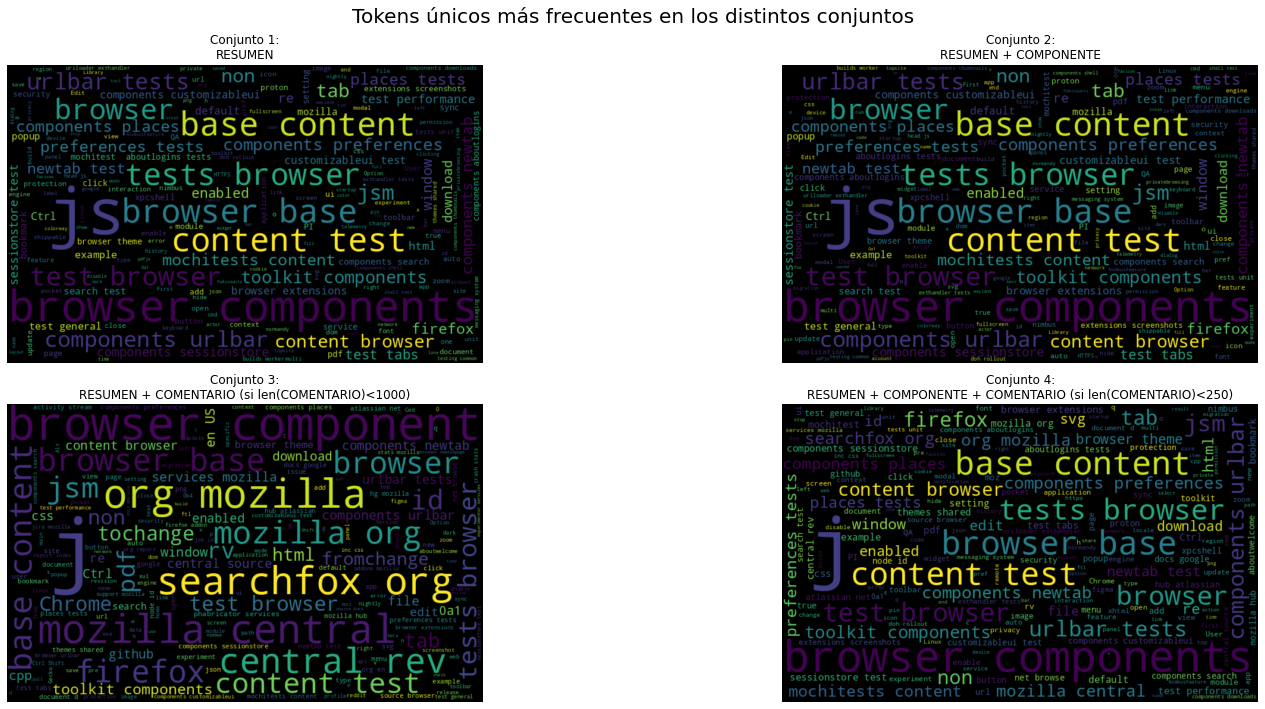

In [25]:
from wordcloud import WordCloud

text1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text1_tokens))
text2_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text2_tokens))
text3_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text3_tokens))
text4_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_text4_tokens))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(text1_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(text2_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(text3_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(text4_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()

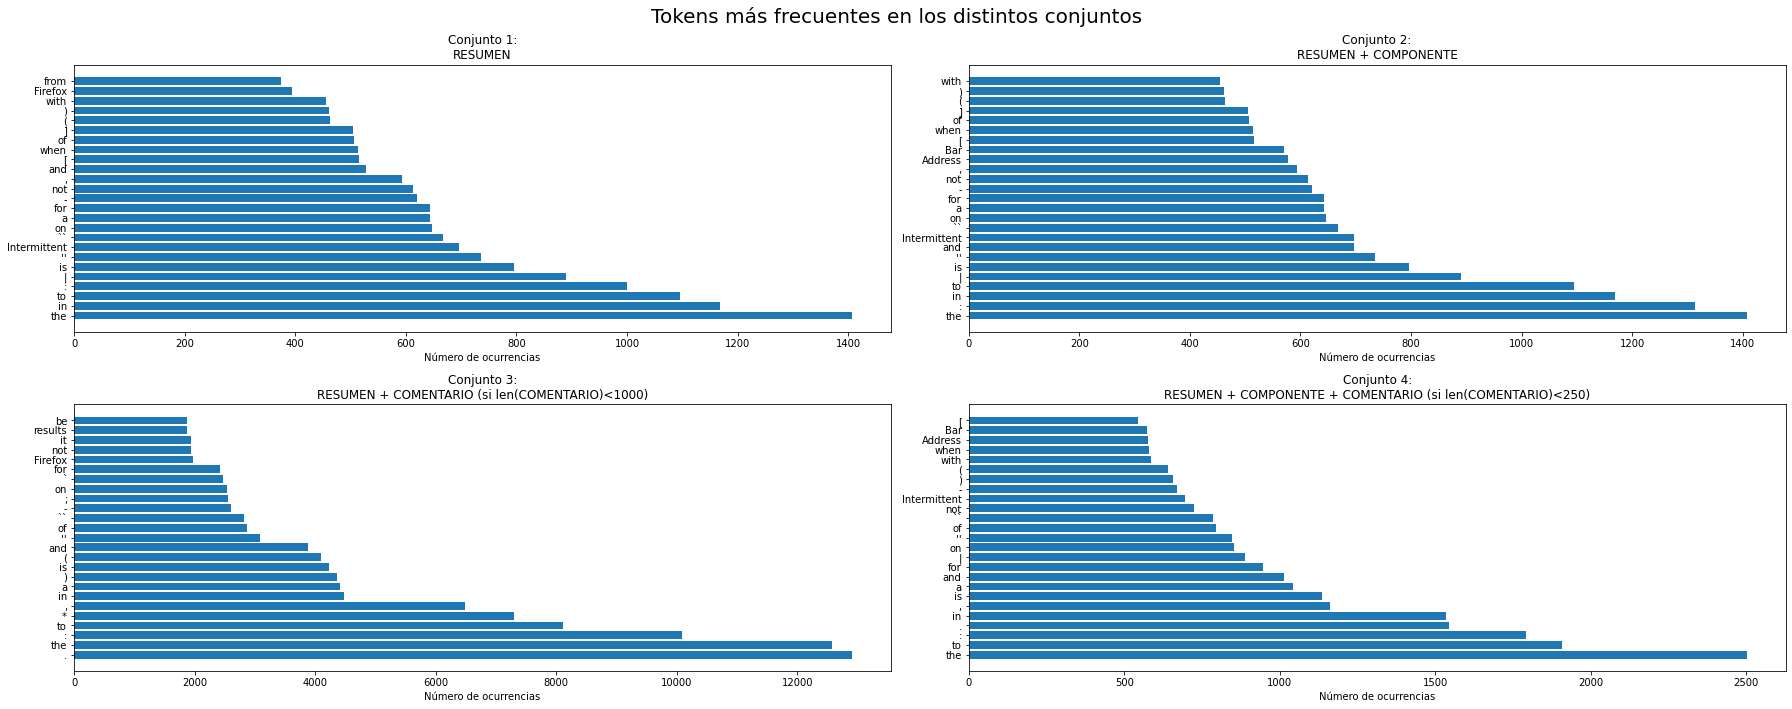

In [26]:
from collections import Counter

text1_counter = Counter(word for tokens in df_reports['text1_tokens'] for word in tokens)
text2_counter = Counter(word for tokens in df_reports['text2_tokens'] for word in tokens)
text3_counter = Counter(word for tokens in df_reports['text3_tokens'] for word in tokens)
text4_counter = Counter(word for tokens in df_reports['text4_tokens'] for word in tokens)

text1_counter_25 = text1_counter.most_common(25)
text2_counter_25 = text2_counter.most_common(25)
text3_counter_25 = text3_counter.most_common(25)
text4_counter_25 = text4_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(text1_counter_25)), [count for word, count in text1_counter_25], align='center')
axs[0, 0].set_yticks(range(len(text1_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in text1_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(text2_counter_25)), [count for word, count in text2_counter_25], align='center')
axs[0, 1].set_yticks(range(len(text2_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in text2_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(text3_counter_25)), [count for word, count in text3_counter_25], align='center')
axs[1, 0].set_yticks(range(len(text3_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in text3_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(text4_counter_25)), [count for word, count in text4_counter_25], align='center')
axs[1, 1].set_yticks(range(len(text4_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in text4_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()

### Tokens comunes por parejas

In [27]:
import warnings
warnings.filterwarnings('ignore')

df_duplicate_pairs['text1M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text1M']]
df_duplicate_pairs['text1D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text1D']]
df_duplicate_pairs['text2M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text2M']]
df_duplicate_pairs['text2D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text2D']]
df_duplicate_pairs['text3M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text3M']]
df_duplicate_pairs['text3D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text3D']]
df_duplicate_pairs['text4M_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text4M']]
df_duplicate_pairs['text4D_tokens'] = [word_tokenize(s.lower()) for s in df_duplicate_pairs['text4D']]

df_duplicate_pairs['text1M_unique_tokens'] = df_duplicate_pairs['text1M_tokens'].apply(set)
df_duplicate_pairs['text1D_unique_tokens'] = df_duplicate_pairs['text1D_tokens'].apply(set)
df_duplicate_pairs['text2M_unique_tokens'] = df_duplicate_pairs['text2M_tokens'].apply(set)
df_duplicate_pairs['text2D_unique_tokens'] = df_duplicate_pairs['text2D_tokens'].apply(set)
df_duplicate_pairs['text3M_unique_tokens'] = df_duplicate_pairs['text3M_tokens'].apply(set)
df_duplicate_pairs['text3D_unique_tokens'] = df_duplicate_pairs['text3D_tokens'].apply(set)
df_duplicate_pairs['text4M_unique_tokens'] = df_duplicate_pairs['text4M_tokens'].apply(set)
df_duplicate_pairs['text4D_unique_tokens'] = df_duplicate_pairs['text4D_tokens'].apply(set)

df_duplicate_pairs['text1M_unique_tokens_len'] = df_duplicate_pairs['text1M_unique_tokens'].apply(len)
df_duplicate_pairs['text1D_unique_tokens_len'] = df_duplicate_pairs['text1D_unique_tokens'].apply(len)
df_duplicate_pairs['text2M_unique_tokens_len'] = df_duplicate_pairs['text2M_unique_tokens'].apply(len)
df_duplicate_pairs['text2D_unique_tokens_len'] = df_duplicate_pairs['text2D_unique_tokens'].apply(len)
df_duplicate_pairs['text3M_unique_tokens_len'] = df_duplicate_pairs['text3M_unique_tokens'].apply(len)
df_duplicate_pairs['text3D_unique_tokens_len'] = df_duplicate_pairs['text3D_unique_tokens'].apply(len)
df_duplicate_pairs['text4M_unique_tokens_len'] = df_duplicate_pairs['text4M_unique_tokens'].apply(len)
df_duplicate_pairs['text4D_unique_tokens_len'] = df_duplicate_pairs['text4D_unique_tokens'].apply(len)

df_duplicate_pairs['text1_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text1M_unique_tokens'] & row['text1D_unique_tokens'], axis=1)
df_duplicate_pairs['text2_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text2M_unique_tokens'] & row['text2D_unique_tokens'], axis=1)
df_duplicate_pairs['text3_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text3M_unique_tokens'] & row['text3D_unique_tokens'], axis=1)
df_duplicate_pairs['text4_common_tokens'] = df_duplicate_pairs.apply(lambda row: row['text4M_unique_tokens'] & row['text4D_unique_tokens'], axis=1)

df_duplicate_pairs['text1_common_tokens_len'] = df_duplicate_pairs['text1_common_tokens'].apply(len)
df_duplicate_pairs['text2_common_tokens_len'] = df_duplicate_pairs['text2_common_tokens'].apply(len)
df_duplicate_pairs['text3_common_tokens_len'] = df_duplicate_pairs['text3_common_tokens'].apply(len)
df_duplicate_pairs['text4_common_tokens_len'] = df_duplicate_pairs['text4_common_tokens'].apply(len)

In [28]:
df_duplicate_pairs[[
    'text1M_unique_tokens_len', 'text1D_unique_tokens_len', 'text2M_unique_tokens_len', 'text2D_unique_tokens_len',
    'text3M_unique_tokens_len', 'text3D_unique_tokens_len', 'text4M_unique_tokens_len', 'text4D_unique_tokens_len'
]].describe()

,text1M_unique_tokens_len,text1D_unique_tokens_len,text2M_unique_tokens_len,text2D_unique_tokens_len,text3M_unique_tokens_len,text3D_unique_tokens_len,text4M_unique_tokens_len,text4D_unique_tokens_len
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.800000,12.238000,12.528000,13.741000,41.457000,45.941000,14.517000,14.967000
std,5.583473,6.183655,5.590928,6.300604,33.219387,32.057936,8.522344,7.737557
min,2.000000,1.000000,3.000000,2.000000,4.000000,2.000000,3.000000,2.000000
25%,6.000000,7.000000,8.000000,9.000000,7.000000,15.000000,8.000000,9.000000
50%,9.000000,11.000000,11.000000,12.000000,35.500000,43.000000,12.000000,13.000000
75%,14.000000,16.000000,15.000000,17.000000,70.000000,71.000000,17.000000,18.000000
max,39.000000,39.000000,41.000000,40.000000,129.000000,127.000000,56.000000,47.000000


In [29]:
df_duplicate_pairs[['text1_common_tokens_len', 'text2_common_tokens_len', 'text3_common_tokens_len', 'text4_common_tokens_len']].describe()

,text1_common_tokens_len,text2_common_tokens_len,text3_common_tokens_len,text4_common_tokens_len
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,3.420000,4.638000,14.576000,4.93900
std,3.701256,3.853025,15.021913,4.07896
min,0.000000,0.000000,0.000000,0.00000
25%,1.000000,2.000000,3.000000,3.00000
50%,3.000000,4.000000,9.000000,4.00000
75%,4.000000,6.000000,22.000000,6.00000
max,35.000000,36.000000,87.000000,36.00000


In [30]:
rank = {}
for i,row in df_duplicate_pairs.iterrows():
    for t in row['text1_common_tokens']:
        if t in rank:
            rank[t] += 1
        else:
            rank[t] = 1
rank = sorted(rank.items(), key=lambda x: x[1], reverse=True)

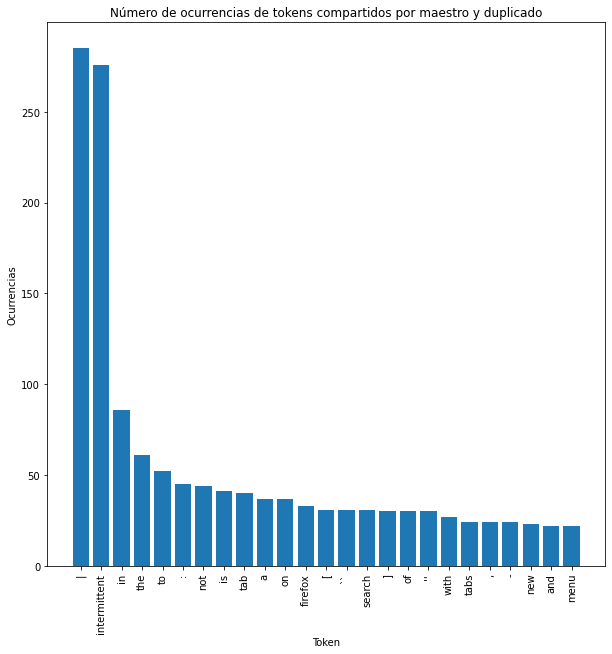

In [31]:
TOP_TOKENS = 25
plt.figure(figsize=(10,10))
plt.bar(range(len(rank[:TOP_TOKENS])), [x[1] for x in rank[:TOP_TOKENS]], align='center')
plt.xticks(range(len(rank[:TOP_TOKENS])), [x[0] for x in rank[:TOP_TOKENS]], rotation=90)
plt.xlabel('Token')
plt.ylabel('Ocurrencias')
plt.title('Número de ocurrencias de tokens compartidos por maestro y duplicado')
plt.show()


# Persistir los reportes y pares de reportes

In [32]:
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_reports[[
    'report_id', 'creation_time', 'status', 'component', 'dupe_of', 'summary', 'comments',
    'text1', 'text2', 'text3', 'text4'
]].to_pickle('data/raw_reports.pkl')

df_report_pairs[[
    'type', 'id_M', 'id_D', 'statusM', 'statusD', 'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM', 'commentsD',
    'text1M', 'text1D', 'text2M', 'text2D', 'text3M', 'text3D', 'text4M', 'text4D'
]].to_pickle('data/raw_report_pairs.pkl')